In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

In [2]:
img = nib.load("/home/stefano/projects/augmentation_tesi/failed_processed/sub-OAS30009/ses-d0148/anat/sub-OAS30009_ses-d0148_run-01_T1w_processed.nii.gz")

In [3]:
data = img.get_fdata()
data.shape

(91, 109, 91)

(-0.5, 108.5, 90.5, -0.5)

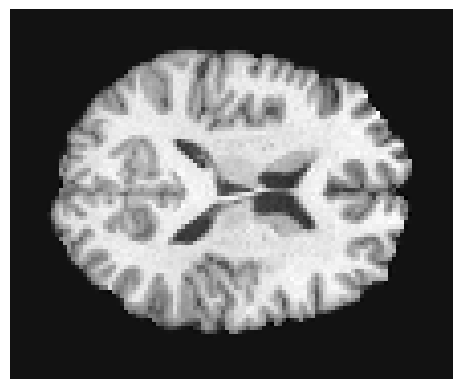

In [4]:
plt.imshow(data[:,:,45],cmap='gray')
plt.axis("off")

In [5]:
imgTensor = torch.tensor(data)

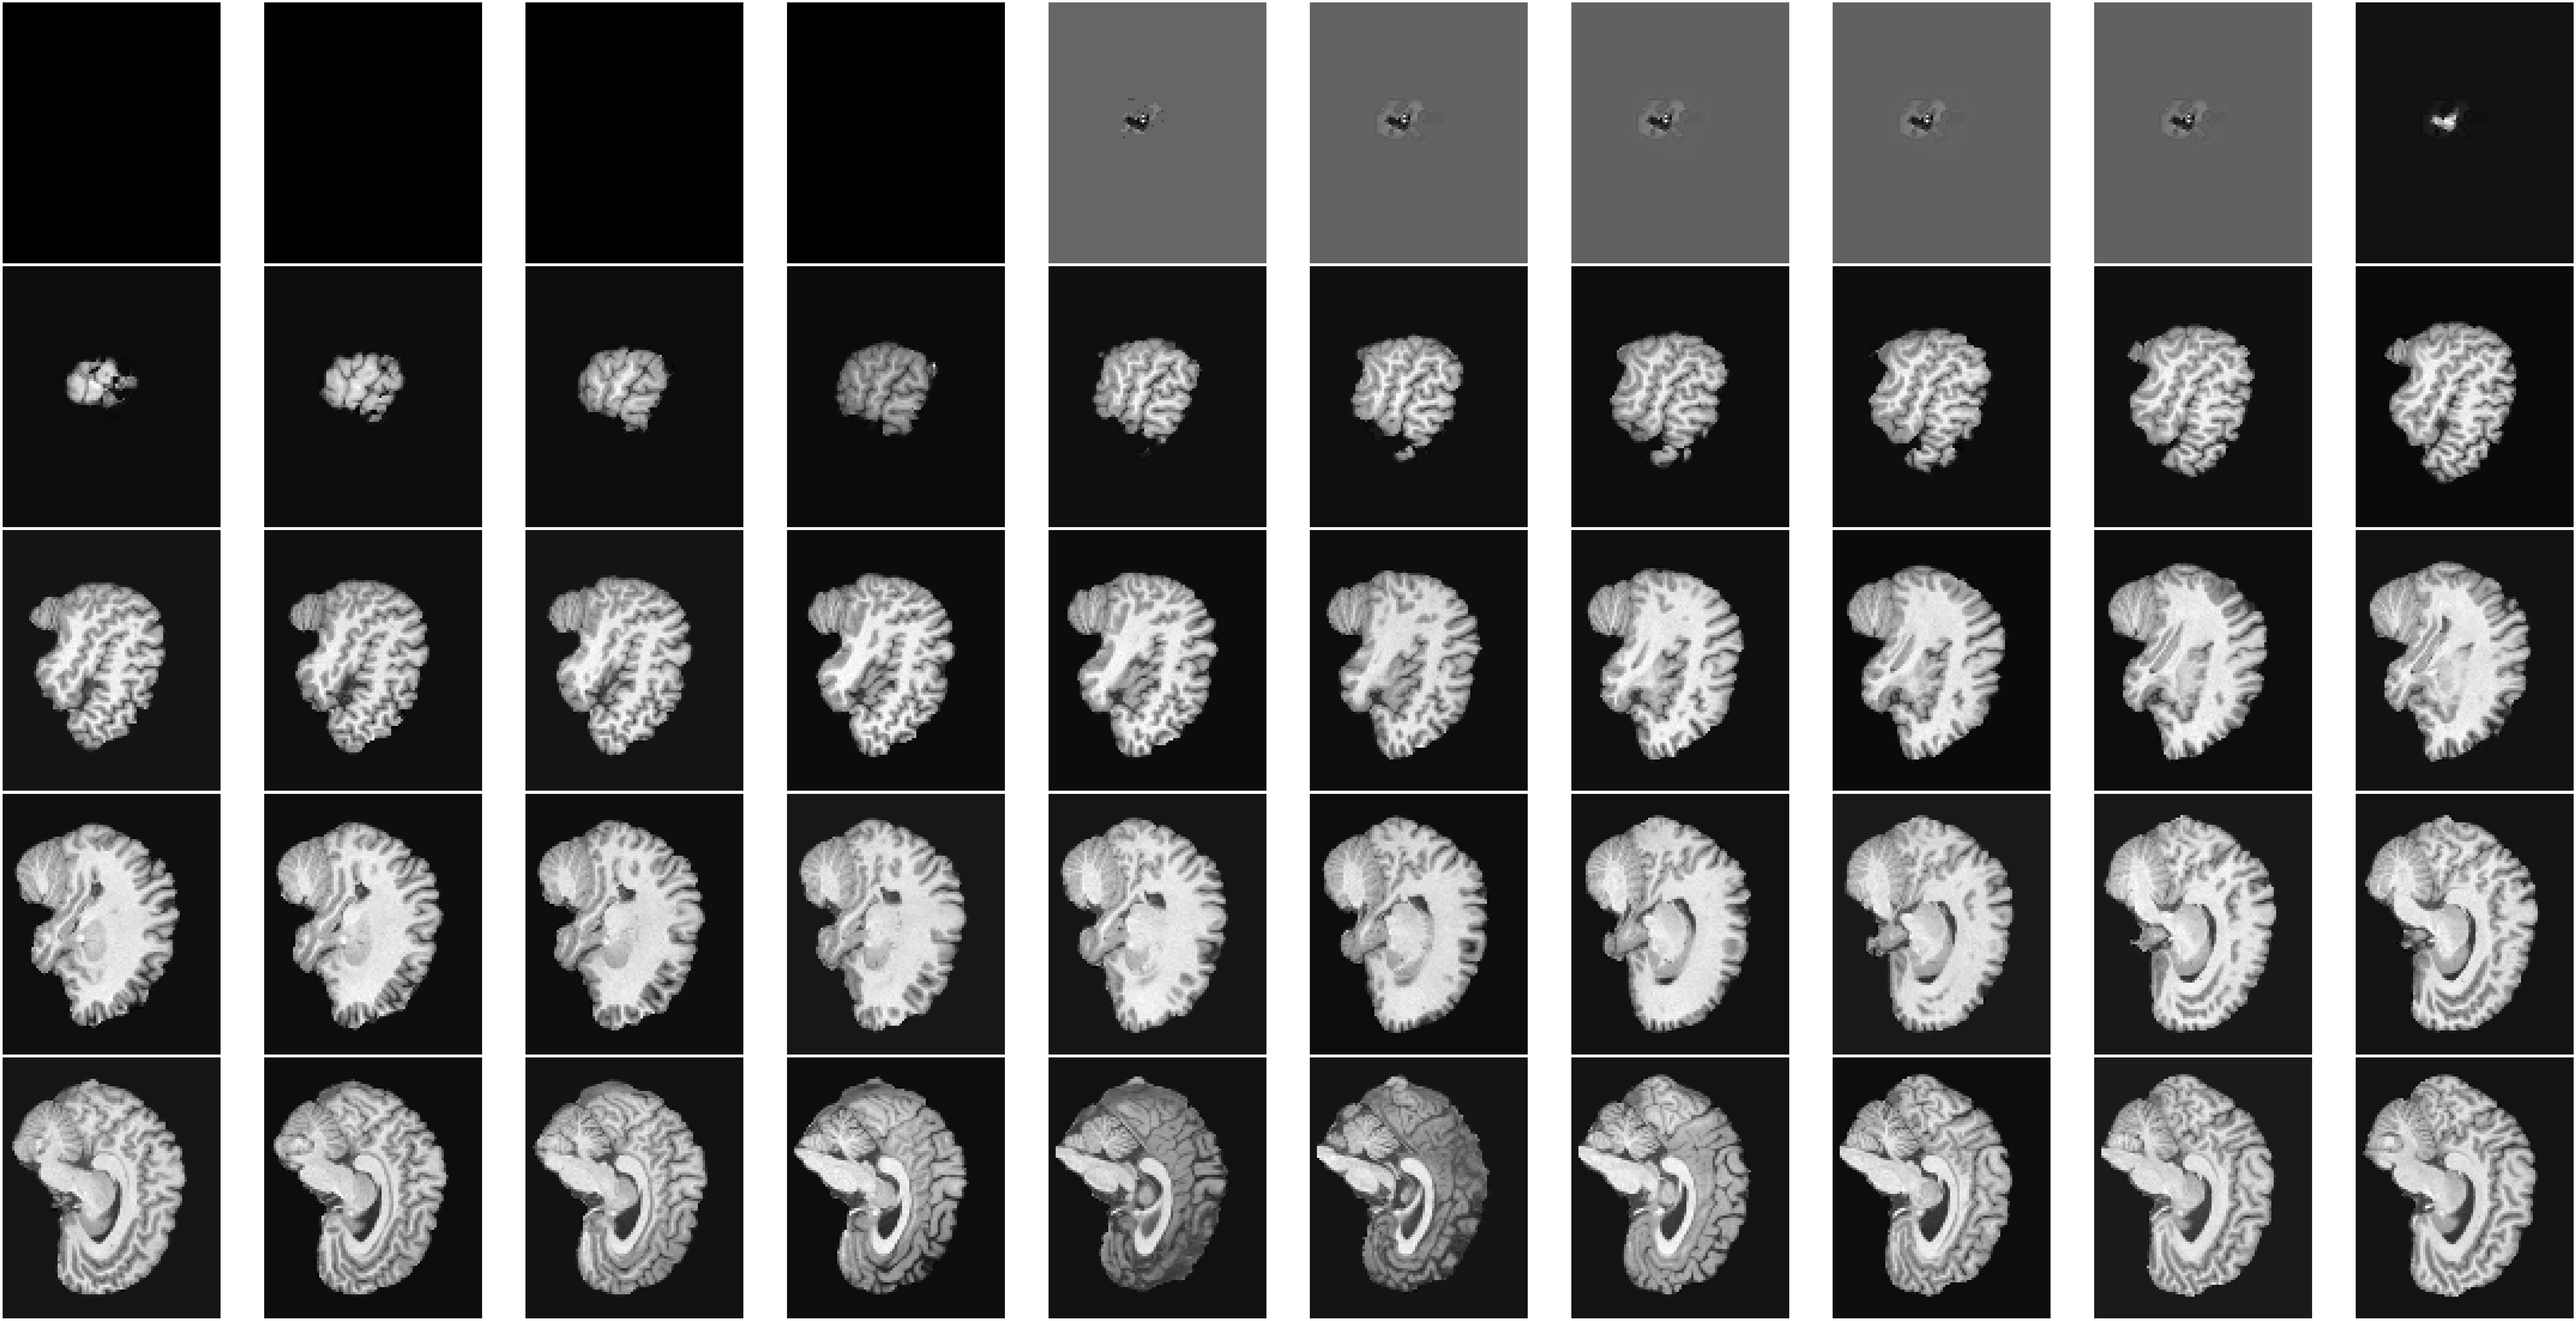

In [6]:
fig, axes = plt.subplots(5, 10, figsize=(100, 50))
for i in range(5):
        for j in range(10):
                axes[i][j].matshow(imgTensor[i*10 +j], cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8) #regola padding tra ed attorno i subplots

In [10]:
pppp = data

(91, 109, 91)

In [6]:
from pyraug.models.nn import BaseEncoder, BaseDecoder
import torch.nn as nn

In [7]:
class Encoder_Conv(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.layers = nn.Sequential(
            nn.Conv2d(self.n_channels, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc1 = nn.Sequential(nn.Linear(32 * 14 * 12, 400), nn.ReLU())

        self.mu = nn.Linear(400, self.latent_dim)
        self.std = nn.Linear(400, self.latent_dim)

    def forward(self, x):
        out = self.layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return self.mu(out), self.std(out)


class Decoder_Conv(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)

        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 400), nn.ReLU(), nn.Linear(400, 32 * 14 * 12), nn.ReLU()
        )

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=0,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=self.n_channels,
                kernel_size=2,
                stride=1,
            ),
            nn.BatchNorm2d(self.n_channels),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.fc1(z)
        out = out.view(out.size(0), 32, 14, 12)
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        return out

In [8]:
#1) Definizione configurazione del modello
from pyraug.models.rhvae import RHVAEConfig

model_config = RHVAEConfig(
    input_dim=109*91, # Dimensione input. This is needed since will use a predefined metric network that requires the input dim to be                           # built automatically
    latent_dim=10 #dimensione spazio latente
    )

#2) Definizione encoder e decoder
encoder = Encoder_Conv(model_config) #ecoder
decoder= Decoder_Conv(model_config) #decoder

#3) Costruzione del modello RHVAE
from pyraug.models import RHVAE

model = RHVAE(
    model_config=model_config,
    encoder=encoder,
    decoder=decoder
)

In [11]:
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines.training import TrainingPipeline

In [12]:
#Setting dei parametri di addestramento del modello generativo
config = TrainingConfig(
    output_dir='/home/stefano/projects/augmentation_tesi/testing/my_model',
    no_cuda=True,
    train_early_stopping=50,
    learning_rate=1e-3,
    steps_saving=None,
    batch_size=200, # Set to 200 for demo purposes to speed up (default: 50)
    max_epochs=500 # Set to 500 for demo purposes. Augment this in your case to access to better generative model (default: 20000)
)

#Si crea e si applica la Pipeline sul dataset di training
torch.manual_seed(8)

#Creazione Pipeline
pipeline = TrainingPipeline(training_config=config)

In [13]:
#Applicazione Pipeline sui dati
pipeline(train_data=imgTensor, log_output_dir='/home/stefano/projects/augmentation_tesi/testing/output_logs')


Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None



ModelError: Error when calling forward method from model. Potential issues: 
 - Wrong model architecture -> check encoder, decoder and metric architecture if you provide yours 
 - The data input dimension provided is wrong -> when no encoder, decoder or metric provided, a network is built automatically but requires the shape of the flatten input data.
Exception raised: <class 'RuntimeError'> with message: all elements of input should be between 0 and 1